2025-05-08 00:05:33.404269: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-08 00:05:33.404296: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-08 00:05:33.404301: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746655533.404522  405965 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746655533.404821  405965 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-05-08 00:05:35.822838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-08 00:05:37.118389: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


313/313 ━━━━━━━━━━━━━━━━━━━━ 291s 915ms/step - accuracy: 0.4095 - loss: 2.4204 - val_accuracy: 0.6805 - val_loss: 1.1088
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 294s 936ms/step - accuracy: 0.6484 - loss: 1.2245 - val_accuracy: 0.7045 - val_loss: 1.0427
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.6843 - loss: 1.0987 - val_accuracy: 0.7114 - val_loss: 1.0186
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 921ms/step - accuracy: 0.7016 - loss: 1.0296 - val_accuracy: 0.7205 - val_loss: 0.9930
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 955ms/step - accuracy: 0.7139 - loss: 0.9861 - val_accuracy: 0.7225 - val_loss: 0.9958
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 928ms/step - accuracy: 0.7242 - loss: 0.9467 - val_accuracy: 0.7248 - val_loss: 0.9910
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 300s 958ms/step - accuracy: 0.7275 - loss: 0.9282 - val_accuracy: 0.7248 - val_loss: 0.9934
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.7343 - loss: 0.9092 - v

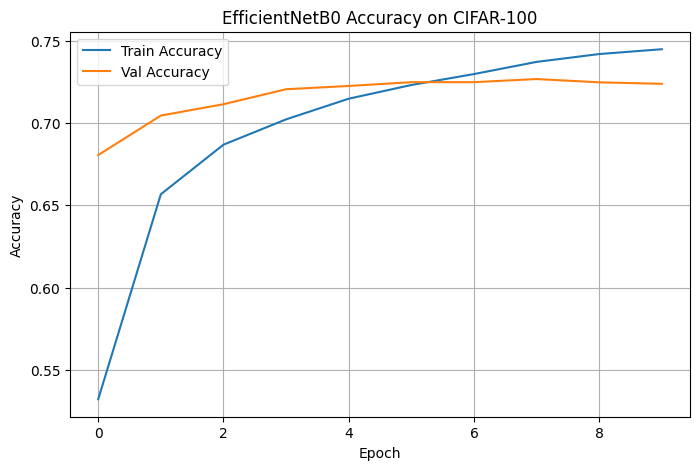

Final Validation Accuracy (EfficientNetB0): 72.38%


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load CIFAR-100 dataset with 80/20 split
(ds_train, ds_val), ds_info = tfds.load(
    "cifar100",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Get class info
num_classes = ds_info.features['label'].num_classes

# Preprocessing for EfficientNetB0
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

batch_size = 128
train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load EfficientNetB0 base
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Freeze for now

# Add classifier
model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Accuracy on CIFAR-100')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Final val accuracy
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy (EfficientNetB0): {final_val_acc:.2f}%")
